<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deeptrack
!pip install --pre deeplay

### **Getting data from Deeptrack**

In [18]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [14]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[7.82166873e-03 7.90599816e-03 7.90673311e-03 ... 1.60696499e+01
 1.60767052e+01 1.60769774e+01]
40960
16.076977424571876
The pixel values are not binary.


### **Plotting the images**

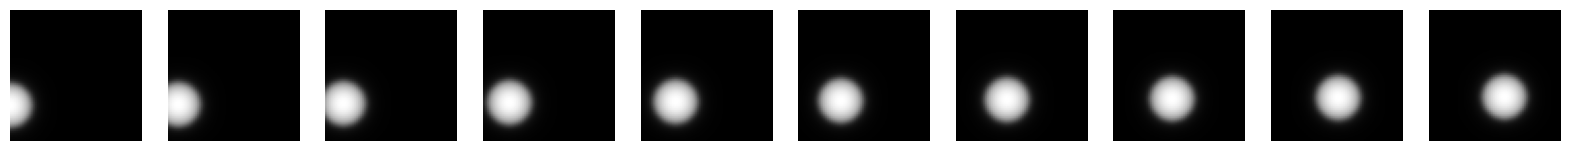

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [22]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        self.std = np.std(all_data)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


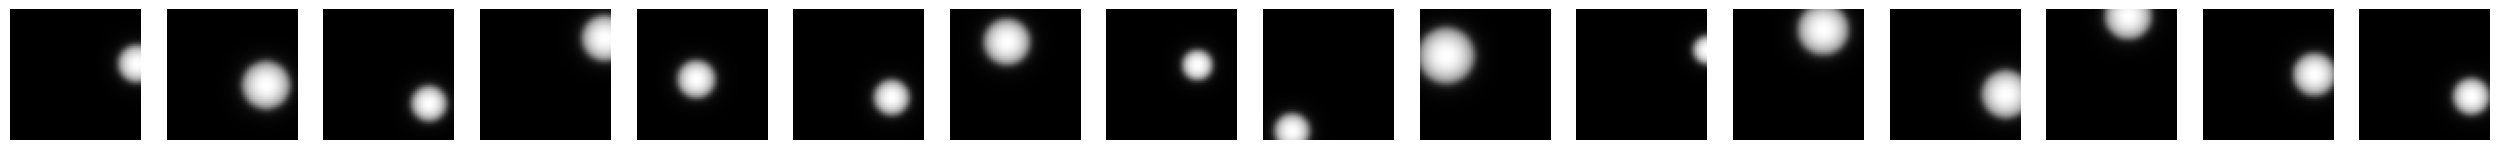

In [23]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),  # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),   # [batch, 8, H/16, W/16]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),    # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, H, W]
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model64(nn.Module):
    def __init__(self):
        super(Model64, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            nn.ReLU()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model128(nn.Module):
    def __init__(self):
        super(Model128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model256(nn.Module):
    def __init__(self):
        super(Model256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model512(nn.Module):
    def __init__(self):
        super(Model512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training the models**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


### **Models with different bottleneck sizes**

In [62]:
# Create the model with bottleneck 64
model8 = Model8()

In [63]:
# Define the optimizer and loss function
optimizer = optim.Adam(model8.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses8, val_losses8 = train_nn(model8, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 1.0035, Val Loss: 0.9976
Epoch 2/25 - Train Loss: 0.9244, Val Loss: 0.7361
Epoch 3/25 - Train Loss: 0.5710, Val Loss: 0.4328
Epoch 4/25 - Train Loss: 0.3878, Val Loss: 0.3330
Epoch 5/25 - Train Loss: 0.3102, Val Loss: 0.2732
Epoch 6/25 - Train Loss: 0.2750, Val Loss: 0.2568
Epoch 7/25 - Train Loss: 0.2572, Val Loss: 0.2449
Epoch 8/25 - Train Loss: 0.2402, Val Loss: 0.2342
Epoch 9/25 - Train Loss: 0.2407, Val Loss: 0.2269
Epoch 10/25 - Train Loss: 0.2237, Val Loss: 0.2198
Epoch 11/25 - Train Loss: 0.2181, Val Loss: 0.2163
Epoch 12/25 - Train Loss: 0.2117, Val Loss: 0.2121
Epoch 13/25 - Train Loss: 0.2087, Val Loss: 0.2106
Epoch 14/25 - Train Loss: 0.2046, Val Loss: 0.2101
Epoch 15/25 - Train Loss: 0.2081, Val Loss: 0.2057
Epoch 16/25 - Train Loss: 0.2077, Val Loss: 0.2017
Epoch 17/25 - Train Loss: 0.1989, Val Loss: 0.2029
Epoch 18/25 - Train Loss: 0.2060, Val Loss: 0.1990
Epoch 19/25 - Train Loss: 0.1998, Val Loss: 0.1987
Epoch 20/25 - Train Loss: 0.1928, Val Lo

In [46]:
# Create the model with bottleneck 64
model64 = Model64()

In [47]:
# Define the optimizer and loss function
optimizer = optim.Adam(model64.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses64, val_losses64 = train_nn(model64, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 0.8780, Val Loss: 0.5026
Epoch 2/25 - Train Loss: 0.3200, Val Loss: 0.2061
Epoch 3/25 - Train Loss: 0.1595, Val Loss: 0.1240
Epoch 4/25 - Train Loss: 0.1274, Val Loss: 0.1096
Epoch 5/25 - Train Loss: 0.1009, Val Loss: 0.0945
Epoch 6/25 - Train Loss: 0.0875, Val Loss: 0.0868
Epoch 7/25 - Train Loss: 0.0871, Val Loss: 0.0823
Epoch 8/25 - Train Loss: 0.0781, Val Loss: 0.0796
Epoch 9/25 - Train Loss: 0.0782, Val Loss: 0.0840
Epoch 10/25 - Train Loss: 0.0782, Val Loss: 0.0773
Epoch 11/25 - Train Loss: 0.0781, Val Loss: 0.0761
Epoch 12/25 - Train Loss: 0.0704, Val Loss: 0.0761
Epoch 13/25 - Train Loss: 0.0782, Val Loss: 0.0752
Epoch 14/25 - Train Loss: 0.0712, Val Loss: 0.0747
Epoch 15/25 - Train Loss: 0.0718, Val Loss: 0.0740
Epoch 16/25 - Train Loss: 0.0645, Val Loss: 0.0744
Epoch 17/25 - Train Loss: 0.0655, Val Loss: 0.0731
Epoch 18/25 - Train Loss: 0.0800, Val Loss: 0.0733
Epoch 19/25 - Train Loss: 0.0689, Val Loss: 0.0764
Epoch 20/25 - Train Loss: 0.0821, Val Lo

In [48]:
model128 = Model128()

In [49]:
# Define the optimizer and loss function
optimizer = optim.Adam(model128.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses128, val_losses128 = train_nn(model128, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 0.9498, Val Loss: 0.6047
Epoch 2/25 - Train Loss: 0.3486, Val Loss: 0.1719
Epoch 3/25 - Train Loss: 0.1428, Val Loss: 0.1182
Epoch 4/25 - Train Loss: 0.1142, Val Loss: 0.1026
Epoch 5/25 - Train Loss: 0.1001, Val Loss: 0.0924
Epoch 6/25 - Train Loss: 0.0934, Val Loss: 0.0859
Epoch 7/25 - Train Loss: 0.0826, Val Loss: 0.0829
Epoch 8/25 - Train Loss: 0.0789, Val Loss: 0.0809
Epoch 9/25 - Train Loss: 0.0783, Val Loss: 0.0784
Epoch 10/25 - Train Loss: 0.0772, Val Loss: 0.0777
Epoch 11/25 - Train Loss: 0.0816, Val Loss: 0.0766
Epoch 12/25 - Train Loss: 0.0788, Val Loss: 0.0759
Epoch 13/25 - Train Loss: 0.0683, Val Loss: 0.0751
Epoch 14/25 - Train Loss: 0.0710, Val Loss: 0.0745
Epoch 15/25 - Train Loss: 0.0720, Val Loss: 0.0738
Epoch 16/25 - Train Loss: 0.0737, Val Loss: 0.0744
Epoch 17/25 - Train Loss: 0.0730, Val Loss: 0.0744
Epoch 18/25 - Train Loss: 0.0735, Val Loss: 0.0733
Epoch 19/25 - Train Loss: 0.0711, Val Loss: 0.0729
Epoch 20/25 - Train Loss: 0.0773, Val Lo

In [58]:
model256 = Model256()

In [59]:
# Define the optimizer and loss function
optimizer = optim.Adam(model256.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses256, val_losses256 = train_nn(model256, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 0.7252, Val Loss: 0.3528
Epoch 2/25 - Train Loss: 0.2947, Val Loss: 0.2298
Epoch 3/25 - Train Loss: 0.1879, Val Loss: 0.1289
Epoch 4/25 - Train Loss: 0.1149, Val Loss: 0.0959
Epoch 5/25 - Train Loss: 0.0990, Val Loss: 0.0866
Epoch 6/25 - Train Loss: 0.0840, Val Loss: 0.0818
Epoch 7/25 - Train Loss: 0.0775, Val Loss: 0.0792
Epoch 8/25 - Train Loss: 0.0765, Val Loss: 0.0772
Epoch 9/25 - Train Loss: 0.0775, Val Loss: 0.0754
Epoch 10/25 - Train Loss: 0.0743, Val Loss: 0.0746
Epoch 11/25 - Train Loss: 0.0736, Val Loss: 0.0735
Epoch 12/25 - Train Loss: 0.0733, Val Loss: 0.0729
Epoch 13/25 - Train Loss: 0.0772, Val Loss: 0.0725
Epoch 14/25 - Train Loss: 0.0771, Val Loss: 0.0727
Epoch 15/25 - Train Loss: 0.0698, Val Loss: 0.0721
Epoch 16/25 - Train Loss: 0.0734, Val Loss: 0.0719
Epoch 17/25 - Train Loss: 0.0693, Val Loss: 0.0716
Epoch 18/25 - Train Loss: 0.0660, Val Loss: 0.0721
Epoch 19/25 - Train Loss: 0.0712, Val Loss: 0.0715
Epoch 20/25 - Train Loss: 0.0662, Val Lo

In [52]:
model512 = Model512()

In [53]:
# Define the optimizer and loss function
optimizer = optim.Adam(model512.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses512, val_losses512 = train_nn(model512, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 0.4283, Val Loss: 0.1498
Epoch 2/25 - Train Loss: 0.1562, Val Loss: 0.1729
Epoch 3/25 - Train Loss: 0.1156, Val Loss: 0.0966
Epoch 4/25 - Train Loss: 0.0953, Val Loss: 0.0858
Epoch 5/25 - Train Loss: 0.0756, Val Loss: 0.0793
Epoch 6/25 - Train Loss: 0.0793, Val Loss: 0.0763
Epoch 7/25 - Train Loss: 0.0794, Val Loss: 0.0734
Epoch 8/25 - Train Loss: 0.0697, Val Loss: 0.0726
Epoch 9/25 - Train Loss: 0.0677, Val Loss: 0.0744
Epoch 10/25 - Train Loss: 0.0654, Val Loss: 0.0729
Epoch 11/25 - Train Loss: 0.0678, Val Loss: 0.0714
Epoch 12/25 - Train Loss: 0.0688, Val Loss: 0.0711
Epoch 13/25 - Train Loss: 0.0686, Val Loss: 0.0709
Epoch 14/25 - Train Loss: 0.0691, Val Loss: 0.0707
Epoch 15/25 - Train Loss: 0.0641, Val Loss: 0.0707
Epoch 16/25 - Train Loss: 0.0688, Val Loss: 0.0707
Epoch 17/25 - Train Loss: 0.0675, Val Loss: 0.0705
Epoch 18/25 - Train Loss: 0.0676, Val Loss: 0.0704
Epoch 19/25 - Train Loss: 0.0675, Val Loss: 0.0705
Epoch 20/25 - Train Loss: 0.0687, Val Lo

### **Visualizing the results**

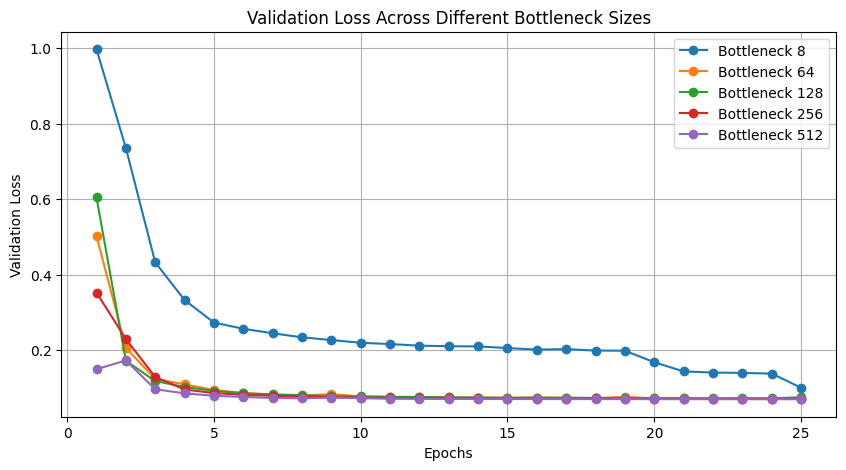

In [64]:
# Assuming all models were trained for the same number of epochs
epochs = range(1, len(val_losses8) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses8, label='Bottleneck 8', marker='o')
plt.plot(epochs, val_losses64, label='Bottleneck 64', marker='o')
plt.plot(epochs, val_losses128, label='Bottleneck 128', marker='o')
plt.plot(epochs, val_losses256, label='Bottleneck 256', marker='o')
plt.plot(epochs, val_losses512, label='Bottleneck 512', marker='o')

plt.title('Validation Loss Across Different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

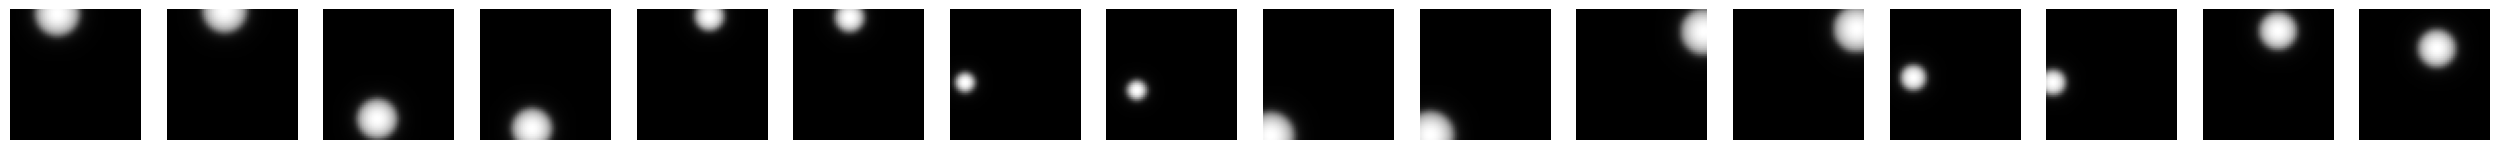

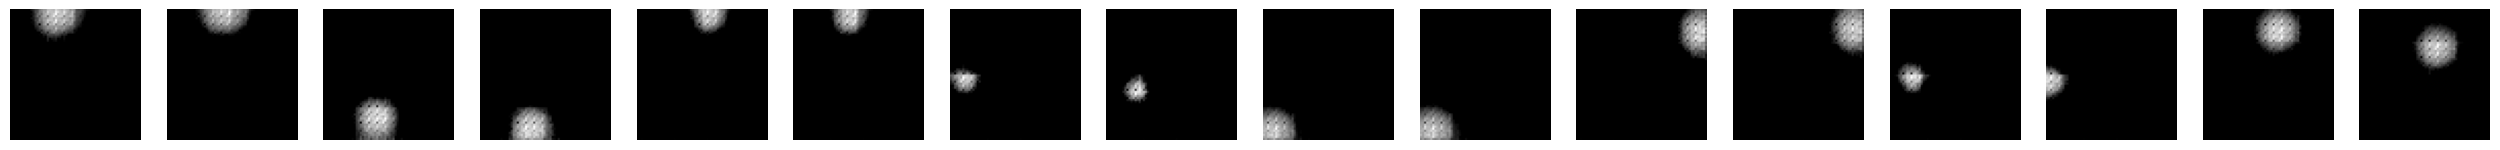

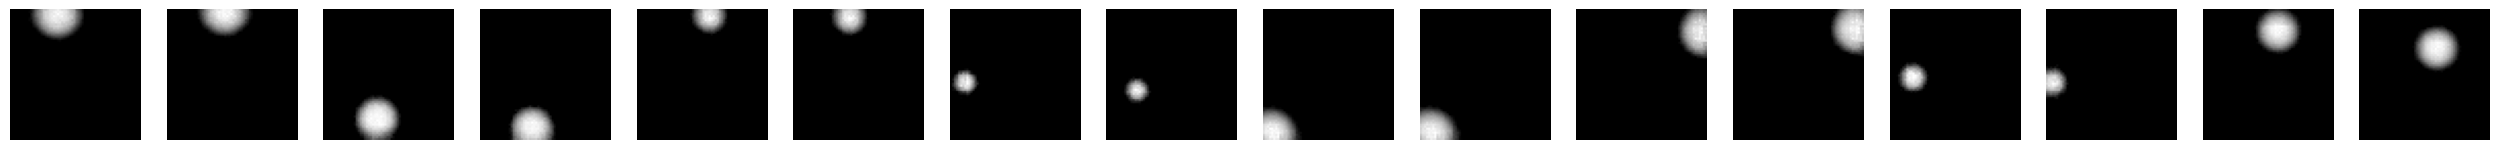

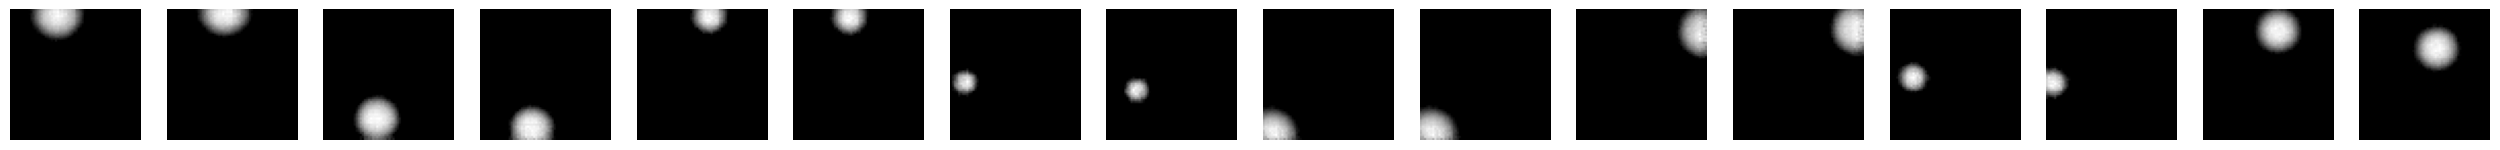

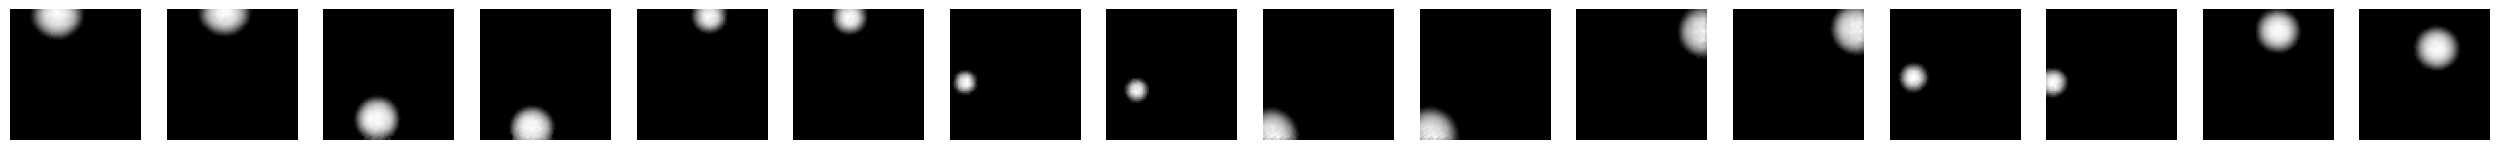

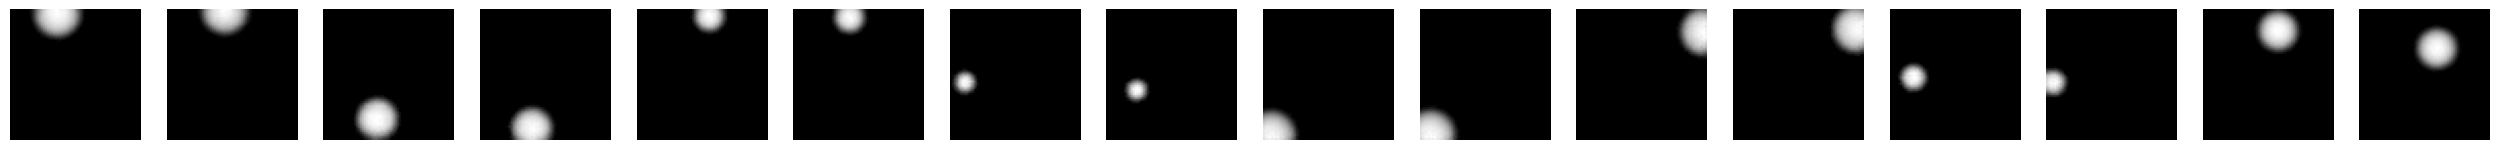

In [65]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        break  # Remove break to process more batches

### **Vision transformer**

In [ ]:
import torch
import torch.nn as nn

class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        # Initialize weights and biases with uniform distribution
        self.weights_linear = nn.Parameter(torch.empty(seq_len).uniform_(-0.1, 0.1))
        self.bias_linear = nn.Parameter(torch.empty(seq_len).uniform_(-0.1, 0.1))
        self.weights_periodic = nn.Parameter(torch.empty(seq_len).uniform_(-0.1, 0.1))
        self.bias_periodic = nn.Parameter(torch.empty(seq_len).uniform_(-0.1, 0.1))

    def forward(self, x):
        # x should have dimensions [batch_size, seq_len]
        # Compute linear component
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)  # Add an extra dimension for concatenation

        # Compute periodic component
        time_periodic = torch.sin(self.weights_periodic * x + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)  # Add an extra dimension for concatenation

        # Concatenate both linear and periodic components along the last dimension
        return torch.cat((time_linear, time_periodic), dim=-1)


In [ ]:
class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        # Initialize layers for query, key, and value
        self.query = nn.Linear(d_k, d_k)  # Assuming the input dimension is d_k for simplicity
        self.key = nn.Linear(d_k, d_k)
        self.value = nn.Linear(d_k, d_v)

    def forward(self, inputs):
        # Assuming inputs is a tuple (query_seq, key_seq, value_seq)
        q = self.query(inputs[0])  # Generate queries
        k = self.key(inputs[1])    # Generate keys
        v = self.value(inputs[2])  # Generate values

        # Calculate the dot product of queries and keys, and apply scaling
        attn_weights = torch.bmm(q, k.transpose(1, 2)) / (self.d_k ** 0.5)
        # Apply softmax to get probabilities
        attn_weights = F.softmax(attn_weights, dim=-1)

        # Multiply weights by values
        attn_out = torch.bmm(attn_weights, v)
        return attn_out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # shape (B, emb_size, H/P, W/P)
        x = x.flatten(2)  # shape (B, emb_size, N)
        x = x.transpose(1, 2)  # shape (B, N, emb_size)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, depth=6):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(layer, num_layers=depth)

    def forward(self, x):
        return self.encoder(x)

class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, emb_size=768, num_heads=8, depth=6, seq_len=10):
        super().__init__()
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, emb_size=emb_size)
        self.transformer_encoder = TransformerEncoder(emb_size=emb_size, num_heads=num_heads, depth=depth)
        self.time2vector = Time2Vector(seq_len)
        self.single_attention = SingleAttention(emb_size, emb_size)
        self.head = nn.Linear(emb_size, emb_size)

    def forward(self, x, timestamps):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)
        class_token = x[:, 0, :]  # Assuming the first token is the class token
        time_features = self.time2vector(timestamps)
        class_token = torch.cat((class_token, time_features), dim=-1)
        class_token = self.single_attention((class_token, class_token, class_token))
        x = self.head(class_token)
        return x

# Assuming Time2Vector and SingleAttention are defined as provided earlier


In [ ]:
model = VisionTransformer()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Sample input data
images = torch.randn(10, 3, 224, 224)  # Batch of 10 images
timestamps = torch.randn(10, 10)  # Corresponding timestamps

# Training loop
for epoch in range(10):
    optimizer.zero_grad()
    output = model(images, timestamps)
    loss = criterion(output, images)  # This would be your target reconstruction; adjust as needed
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}: Loss {loss.item()}')
